In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
from copy import deepcopy

In [3]:
from spacetime.spacetime import SpaceTime
from spacetime.simulate import Simulator
from spacetime.metrics import count_accuracy, adjacency_error
from spacetime.models import MLPEncoder, MLPDecoder
from spacetime.training import train, acyclicity
from spacetime.utils import arguments, spacetime_mutilator, graph_clipper
from spacetime.sampler import NodeData, GraphSampler

simulating a random 3-degree erdos-renyi dag with range (0.5, 2.0) (seed 0)


array([[ 0.        ,  0.        , -0.89683342,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.5281847 , -1.41814358],
       [ 0.        ,  0.        ,  0.        , -1.50015007,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.15554793],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

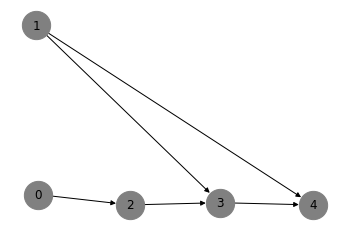

In [4]:
args = arguments(node_dict = {0:[0,1], 1:[2], 2:[3], 3:[4]})
args.data_sample_size=10000
args.noise_scale = 0.6
args.graph_type='erdos-renyi'
args.graph_sem_type='linear-gauss'
args.graph_linear_type='linear'
args.graph_degree = 3

# training hyperparameters
args.graph_threshold=0.3  # 0.3 is good 0.2 is error prune
args.tau_A=1e-8
args.ordered_graph=True
args.use_A_connect_loss=False
args.use_A_positiver_loss=False

args.seed=42
args.epochs=5
args.batch_size=100 # note: should be divisible by sample size otherwise throw an error
args.encoder_hidden=64
args.decoder_hidden=64

g = SpaceTime.from_spacelike([0,1,3,2,4], simulate=True,
                             degree=args.graph_degree, graph_type=args.graph_type, 
                             w_range=(0.5,2.0), force_positive=False, seed=0)
g.show_adj()
g.draw_graph()

In [5]:
col_plot_dict = {0:(4,3), 1:(4,1), 2:(3,2), 3:(2,0)}
mutilate = 3
observe = 4
latent = 1

In [6]:
g.data = Simulator.sem(graph=g.graph, n=args.data_sample_size, x_dims=args.x_dims, 
                       sem_type=args.graph_sem_type, linear_type=args.graph_linear_type, 
                       noise_scale=args.noise_scale, seed=args.seed)
train_loader, test_loader = g.torch_loader(g.data, args.batch_size)

simulating 10000 samples from a linear-gauss sem with linear causal effects


In [7]:
# n_trials = 1

# shd_trials = list()
# err_trials = list()
# kl_trials = list()
# nll_trials = list()
# elbo_trials = list()
# graph_trials = list()

# for trial in range(n_trials):
#     shd_train, err_train = list(), list()
#     kl_train, nll_train, elbo_train = list(), list(), list()
#     hA_train = list()
#     graph_train = list()

#     best_epoch = 0
#     best_ELBO, best_ELBO_graph = np.inf, None
#     best_KL, best_KL_graph = np.inf, None
#     best_NLL, best_NLL_graph = np.inf, None

#     # optimizer step on hyparameters
#     c_A = args.c_A
#     lambda_A = args.lambda_A
    
#     h_A_old, h_A_new = np.inf, torch.tensor(1.)
#     h_tol = args.h_tol
#     k_max_iter = int(args.k_max_iter)

#     #===================================
#     # load modules
#     #===================================
#     # add adjacency matrix A
#     num_nodes = args.data_variable_size
#     adj_A = np.zeros((num_nodes, num_nodes))

#     encoder = MLPEncoder(args.x_dims, args.encoder_hidden, int(args.z_dims), adj_A).double()
#     decoder = MLPDecoder(args.z_dims, args.x_dims, n_hid=args.decoder_hidden).double()

#     #===================================
#     # set up training parameters
#     #===================================
#     optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=args.lr)
#     scheduler = lr_scheduler.StepLR(optimizer, step_size=args.lr_decay, gamma=args.gamma)

#     #===================================
#     # train model
#     #===================================
#     t_total = time.time()
#     for step_k in range(k_max_iter):
#         while c_A < 1e+20:
#             for epoch in range(args.epochs):
#                 ELBO, KL, NLL, origin_A = train(lambda_A, c_A, optimizer, scheduler, 
#                                                 encoder, decoder, train_loader, args)
#                 graph_clone, graph_full, graph = graph_clipper(origin_A, args.graph_threshold)
                
#                 if ELBO < best_ELBO:
#                     best_epoch = epoch
#                     best_ELBO = ELBO
#                     best_ELBO_graph = graph
#                     best_ELBO_graph_full = graph_full

#                 if KL < best_KL:
#                     best_KL = KL
#                     best_KL_graph = graph

#                 if NLL < best_NLL:
#                     best_NLL = NLL
#                     best_NLL_graph = graph
                
#                 hA = acyclicity(graph_clone, args)
#                 fdr, tpr, fpr, shd, nnz = count_accuracy(g.show_adj(), best_ELBO_graph)
#                 err = adjacency_error(g.show_adj(), best_ELBO_graph_full)

#                 shd_train.append(shd)
#                 err_train.append(err)
#                 kl_train.append(best_KL)
#                 nll_train.append(best_NLL)
#                 elbo_train.append(best_ELBO)
#                 hA_train.append(hA)
                
#             graph_train.append(best_ELBO_graph_full)
#             print("Optimization Finished!")
#             print("Best Epoch: {:04d}\t".format(best_epoch),
#                   "ELBO: {:.10f}".format(best_ELBO),
#                   "KL: {:.10f}".format(best_KL),
#                   "NLL: {:.10f}".format(best_NLL))
            
#             if ELBO > 2 * best_ELBO:
#                 break

#             # update parameters
#             h_A_new = acyclicity(graph_clone, args)
#             if h_A_new.item() > 0.25 * h_A_old:
#                 c_A*=10
#             else:
#                 break

#         h_A_old = h_A_new.item()
#         lambda_A += c_A * h_A_new.item()

#         if h_A_new.item() <= h_tol:
#             break

#     print("\nTrial %s finished in %s seconds"%(trial, time.time() - t_total))
#     print('Best ELBO Stats: shd %s err %s\n'%(shd, err))
# #     print(best_ELBO_graph)

# #     print('Ground truth graph')
# #     print(g.show_adj(around=3))
    
#     shd_trials.append(shd_train)
#     err_trials.append(err_train)
#     kl_trials.append(kl_train)
#     nll_trials.append(nll_train)
#     elbo_trials.append(elbo_train)
#     graph_trials.append(best_ELBO_graph)
# pass;

In [8]:
# fig, axs = plt.subplots(1, 5, figsize = (15,3))

# for trial in range(n_trials):
#     axs[0].plot(range(len(err_trials[trial])), err_trials[trial])
#     axs[1].plot(range(len(shd_trials[trial])), shd_trials[trial])
#     axs[2].plot(range(len(kl_trials[trial])), np.log10(kl_trials[trial]))
#     axs[3].plot(range(len(nll_trials[trial])), np.log10(nll_trials[trial]))
#     axs[4].plot(range(len(elbo_trials[trial])), np.log10(elbo_trials[trial]))
# pass;

# Attn Modules

In [9]:
import copy, math
import seaborn as sns

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, 
                vmin=0.0, vmax=1.0, cbar=False, ax=ax)
    
def node_hot(x, pad=(0,0)):
    expanded = torch.eye(x.shape[1])*x.unsqueeze(1)
    return F.pad(expanded, pad=(*pad, 0, 0), mode='constant', value=0)

In [10]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_embed, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_embed)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2) *
                             -(math.log(10000.0) / d_embed))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [11]:
class LinearBlock(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_in, d_hidden, d_out, dropout=0.1):
        super(LinearBlock, self).__init__()
        self.w_1 = nn.Linear(d_in, d_hidden)
        self.w_2 = nn.Linear(d_hidden, d_out)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class EmbedBlock(nn.Module):
    def __init__(self, d_in, d_out):
        super(EmbedBlock, self).__init__()
        self.proj = nn.Linear(d_in, d_out)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        return self.proj(x)

In [12]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, d_embed, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(d_embed, dropout), 2)
        self.d_embed = d_embed

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, d_embed, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.d_embed = d_embed
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = SublayerConnection(d_embed, dropout)
        self.norm = LayerNorm(d_embed)
 
    def forward(self, x, memory):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.norm(self.self_attn(x, x, x))
        x = self.norm(self.src_attn(x, m, m))
        return self.sublayer(x, self.feed_forward)
    
# class DecoderLayer(nn.Module):
#     "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
#     def __init__(self, d_embed, self_attn, src_attn, feed_forward, dropout):
#         super(DecoderLayer, self).__init__()
#         self.d_embed = d_embed
#         self.self_attn = self_attn
#         self.src_attn = src_attn
#         self.feed_forward = feed_forward
#         self.sublayer = clones(SublayerConnection(d_embed, dropout), 3)
 
#     def forward(self, x, memory):
#         "Follow Figure 1 (right) for connections."
#         m = memory
#         x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
#         x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m))
#         return self.sublayer[2](x, self.feed_forward)

In [13]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def clone_encoder(mask, N, **kwargs):
    d_embed, d_hidden = kwargs['d_embed'], kwargs['d_hidden']
    self_attns = [CausalAttention(n_heads, d_embed, mask=mask) for _ in range(N)]
    feed_forwards = [LinearBlock(d_embed, d_hidden, d_embed, dropout=0.1) for _ in range(N)]
    modules = [EncoderLayer(d_embed, self_attn, feed_forward, dropout) 
               for self_attn, feed_forward in zip(self_attns, feed_forwards)]

    return nn.ModuleList(modules)

def clone_decoder(mask, N, **kwargs):
    d_embed, d_hidden = kwargs['d_embed'], kwargs['d_hidden']
    self_attns = [CausalAttention(n_heads, d_embed, mask=mask, mask_self=True) for _ in range(N)]
    src_attns = [CausalAttention(n_heads, d_embed, mask=mask, mask_self=False) for _ in range(N)]
    feed_forwards = [LinearBlock(d_embed, d_hidden, d_embed, dropout=0.1) for _ in range(N)]
    
    modules = [DecoderLayer(d_embed, self_attn, src_attn, feed_forward, dropout) 
               for self_attn, src_attn, feed_forward in zip(self_attns, src_attns, feed_forwards)]
    return nn.ModuleList(modules)

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, mask, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout):
        super(Encoder, self).__init__()
        self.mask = mask
        self.layers = clone_encoder(self.mask, n_layers, d_embed=d_embed, d_hidden=d_hidden, dropout=dropout)
        self.norm = LayerNorm(self.layers[0].d_embed)
        
    def forward(self, x):
        "Pass the input through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)
    
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, mask, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout):
        super(Decoder, self).__init__()
        self.mask = mask
        self.layers = clone_decoder(self.mask, n_layers, d_embed=d_embed, d_hidden=d_hidden, dropout=dropout)
        self.norm = LayerNorm(self.layers[0].d_embed)
        
    def forward(self, x, memory):
        for layer in self.layers:
            x = layer(x, memory)
        return self.norm(x)

In [14]:
# testt = torch.Tensor(g.show_adj())
# testt[testt!=0]=1.0
# testt=testt+1e-5

In [15]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models.
    """
    def __init__(self, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout):
        super(EncoderDecoder, self).__init__()
        self.e_mask = torch.eye(n_nodes).unsqueeze(0)
#         self.e_mask = torch.tril(torch.ones((1, n_nodes, n_nodes)), diagonal=-1)
#         self.d_mask = nn.Parameter(torch.tril(torch.ones((1, n_nodes, n_nodes)), diagonal=-1), requires_grad=True)
#         self.d_mask = nn.Parameter(torch.ones((1, n_nodes, n_nodes)), requires_grad=True)
        self.d_mask = nn.Parameter(torch.ones((1, n_nodes, n_nodes)), requires_grad=True)
#         self.d_mask = testt.transpose(0,1)
        self.encoder = Encoder(self.e_mask, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout)
        self.decoder = Decoder(self.d_mask, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout)
        self.embedder = EmbedBlock(n_nodes, d_embed)
#         self.embedder = nn.Sequential(EmbedBlock(n_nodes, d_embed), PositionalEncoding(d_embed, dropout))
        self.generator = EmbedBlock(d_embed, n_nodes)
        self._init_weights()
        
    def _init_weights(self):
        # This was important from their code. 
        # Initialize parameters with Glorot / fan_avg.
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def encode(self, src):
        src = self.embedder(src)
        src = self.encoder(src)
        return src
    
    def decode(self, tgt, memory):
        tgt = self.embedder(tgt)
        tgt = self.decoder(tgt, memory)
        return tgt
    
    def forward(self, src, tgt):
        "Take in and process masked src and target sequences."
        memory = self.encode(src)
        tgt = self.decode(tgt, memory)
        tgt = self.generator(tgt)
        
        return tgt, memory, self.d_mask # F.softmax(-torch.exp(-(1e-10+torch.abs(self.d_mask)).log()), dim=-1)

In [16]:
class CausalAttention(nn.Module):
    def __init__(self, n_heads, d_embed, mask, mask_self=True, dropout=0.1):
        "Take in model size and number of n_headseads."
        super(CausalAttention, self).__init__()
        assert d_embed % n_heads == 0
        # We assume d_v always equals d_k
        self.d_k = d_embed // n_heads
        self.h = n_heads
        self.linears = clones(nn.Linear(d_embed, d_embed), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.eps = 1e-10
        self.mask = mask
        self.extra_linear = nn.Linear(d_embed, d_embed)
        self.norm = LayerNorm(d_embed)
        
        if mask_self:
            self.mask_add = torch.zeros((mask.shape[-1], mask.shape[-1])).unsqueeze(0)
        else:
            self.mask_add = torch.eye(mask.shape[-1]).unsqueeze(0)
            
    def add_mask(self):
        return (self.eps+self.mask_add+torch.abs(self.mask)).unsqueeze(1)
            
    def get_mask(self):
        return -torch.exp(-self.add_mask().log())
    
    def attention(self, query, key, value, dropout=None):
        "Compute 'Scaled Dot Product Attention'"
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2,-1))/math.sqrt(d_k)
#         scores += torch.abs(((self.mask_add+self.mask).unsqueeze(1)+self.eps)).log()
#         scores += self.penalty()
#         p_attn = F.softmax(scores, dim = -1)
        p_attn = F.softmax(scores, dim = -1)*(self.mask_add+torch.abs(self.mask)).unsqueeze(1)
    
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn
    
    def bmm(self, adj, x):
        return torch.einsum('ij,ajc->aic', adj, x)
        
    def forward(self, query, key, value):
        "Implements Figure 2"
        nbatches = query.size(0)
        # batchwise linear projections from d_embed => n_heads x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
                             for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = self.attention(query, key, value, dropout=self.dropout)
        
        # view contatentation and apply final linear layer 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h*self.d_k)
#         print((self.mask_add+torch.abs(self.mask)).shape, self.linears[-1](x).shape)
        return self.linears[-1](x)
#         return self.extra_linear(F.relu(self.linears[-1](x)))

# Graph Attn

In [47]:
class VecBatch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, tgt=None, pad=0):
        self.src = node_hot(src)
        if tgt is not None:
            self.tgt = tgt[:, :]#node_hot(tgt[:, :], pad=(0,0))
            self.tgt_y = tgt[:, :]#node_hot(tgt[:, :], pad=(0,0))
            self.ntokens = (self.tgt_y != pad).data.sum()
            
def data_graph_gen(spacetime, batch, nbatches):
    for i in range(nbatches):
        data = torch.squeeze(torch.from_numpy(g.data[i*batch:(i+1)*batch]))
        src = Variable(data, requires_grad=False).float()
        tgt = Variable(data, requires_grad=False).float()
        yield VecBatch(src, tgt, 0)

In [48]:
from spacetime.training_att import LagrangeLoss, ActionOpt
from spacetime.training_att import h_A, h_A_timed
from spacetime.utils_att import Parameters
# from spacetime.training_att import train, truth_evaluation

In [49]:
def train(model, train_loader, loss):
    t = time.time()
    model.train()    

    for i, batch in enumerate(train_loader):
        preds, z_train, origin_A = model(batch.src.float(), batch.tgt.float())
        if torch.sum(preds != preds):
            raise ValueError('nan error\n')
        if torch.sum(origin_A != origin_A):
            raise ValueError('nan error\n')

        loss(origin_A.squeeze().transpose(0,1), preds, batch.src.float(), z_train)
    loss.end_epoch()

In [50]:
# Train the simple copy task.
n_nodes=5
d_embed = 10
d_hidden=5*d_embed

n_layers=2
n_heads = 5
dropout=0.1

trn_params = Parameters(batch_size=100, epochs=5)
opt_params = Parameters(constraint=lambda x: h_A(x, n_nodes),
                        lr=0.001, l=1e-2, c=1, h=np.inf, tau=1e-10, 
                        max_iters=50, h_tol=1e-6)

In [51]:
n_trials = 1
shd_trials, err_trials = list(), list()
graph_trials = list()

loss_log = {k:[] for k in ('elbo', 'kld', 'nll')}
param_log = {k:[] for k in ('lr', 'l', 'c', 'h')}

for trial in range(n_trials):
    shd_train, err_train = list(), list()
    graph_train = list()
    
    #===================================
    # load modules
    #===================================

    autoencoder = EncoderDecoder(n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout)
    optimizerL = ActionOpt(autoencoder, opt_params, h_factor=0.25*(2), c_factor=10.0/(3), warmups=500)
    lossL = LagrangeLoss(opt=optimizerL)
    
    #===================================
    # train model
    #===================================
    
    t_total = time.time()
    while optimizerL._iter < optimizerL.max_iter:
        for epoch in range(trn_params.epochs):
            train(autoencoder, data_graph_gen(g, 60, 60), lossL)
#             shd, err = truth_evaluation(g.adj, optimizerL, mod_params.graph_threshold)
#             shd_train.append(shd)
#             err_train.append(err)
#             graph_train.append(optimizerL.adj.data.clone())
        
        print("Iteration: %s, Best Epoch: %s/%s"%(optimizerL._iter, optimizerL.best_epoch, trn_params.epochs))
        print("   ELBO: {:.7f}, KL: 10^{:.3f}, NLL: 10^{:.3f} || h: 10^{:.3f}, c: 10^{:.3f}, l: {:.7f}, lr: {:.7f}".format(
            optimizerL.min_elbo, np.log10(optimizerL.min_kld), np.log10(optimizerL.min_nll),
            np.log10(optimizerL.h), np.log10(optimizerL.c), optimizerL.l, optimizerL.log['lr'][-1])
        )

        # update parameters
        optimizerL.iterate()
        if optimizerL._iter > 10: #or optimizerL.h <= optimizerL.h_tol:
            break
    
    print("\nTrial %s finished in %s seconds"%(trial, time.time() - t_total))
#     print('Best ELBO Stats: shd %s err %s\n'%(shd, err))

#     shd_trials.append(shd_train)
#     err_trials.append(err_train)
#     graph_trials.append(optimizerL.show_adj(mod_params.graph_threshold))
    
    for k,v in loss_log.items():
        v += [optimizerL.log[k]]
        
    for k,v in param_log.items():
        v += [optimizerL.log[k]]
pass;

RuntimeError: size mismatch, m1: [300 x 5], m2: [1 x 10] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

In [22]:
autoencoder.decoder.layers[1].self_attn.linears[0].weight

Parameter containing:
tensor([[ 0.1193, -0.4492,  0.4254,  0.0621,  0.0237,  0.2819,  0.0104, -0.0384,
         -0.2486,  0.2828],
        [-0.3062, -0.1032,  0.2413,  0.3355, -0.4903,  0.3087,  0.0521,  0.3256,
         -0.1620,  0.1895],
        [ 0.1029,  0.2870,  0.4716,  0.2158, -0.2303,  0.1722, -0.0608,  0.0098,
          0.1577,  0.1352],
        [-0.0458, -0.3567,  0.0708,  0.2658, -0.2714,  0.2759, -0.1890,  0.1003,
          0.4124, -0.2212],
        [ 0.2419,  0.1536,  0.5711,  0.3045, -0.3411,  0.2656, -0.1090, -0.5575,
         -0.3022,  0.2990],
        [ 0.1037,  0.4232,  0.2404, -0.1859, -0.5152,  0.5648, -0.1156,  0.3097,
         -0.0942,  0.5054],
        [ 0.7625,  0.6232, -0.0817, -0.1277,  0.5739, -0.5966, -0.0820, -0.4224,
          0.0364, -0.3697],
        [-0.0877,  0.2231, -0.5447, -0.0317, -0.2013, -0.2952,  0.4793, -0.3667,
          0.3009, -0.2715],
        [-0.5126, -0.4344, -0.3224,  0.2834,  0.2986,  0.0407, -0.1337,  0.2643,
         -0.2885, -0.3725

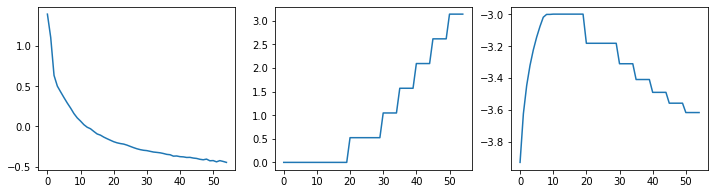

In [23]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))

for trial in range(n_trials):
    axs[0].plot(range(len(loss_log['nll'][trial])), np.log10(loss_log['nll'][trial]))
    axs[1].plot(range(len(param_log['c'][trial])), np.log10(param_log['c'][trial]))
    axs[2].plot(range(len(param_log['lr'][trial])), np.log10(param_log['lr'][trial]))
pass;

In [24]:
def threshold(adj, threshold):
    return nn.Threshold(threshold, 0.0)(adj)-nn.Threshold(threshold, 0.0)(-adj)

def time_scores(adj):
    n_nodes = adj.shape[0]
    I = torch.eye(n_nodes).double()
    expA = torch.matrix_power(I+(1/n_nodes)*torch.tanh(adj)**2, n_nodes)
    scores = torch.div(1.0, torch.sum(expA, dim=1))-torch.div(1.0, torch.sum(expA, dim=0))
    return scores

def time_sort(adj):
    return torch.argsort(time_scores(adj.squeeze()))

testdata = iter(data_graph_gen(g, 30, 60))

In [25]:
batch = next(testdata)
preds, z_train, origin_A = autoencoder(batch.src.float(), batch.tgt.float())

In [26]:
threshold(preds[:1],0.2)
threshold(batch.src.float()[:1], 0.)

tensor([[[-0.2987,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.2391,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.3398,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -2.3008,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -2.9215]]],
       grad_fn=<SubBackward0>)

tensor([[[-0.4071,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.2980,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.5741,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -2.2069,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -3.2560]]])

In [46]:
bmm(origin_A.double(), batch.src.double())[:2]
preds[:2]

tensor([[[-2.9022e-04, -7.9821e-03, -3.3828e-03,  1.0188e-02, -7.9877e-03],
         [-2.0454e-02,  4.0573e-03, -1.2769e-02, -2.7223e-02, -5.3379e-02],
         [-7.4511e-05,  3.1597e-05, -7.6642e-06, -5.8616e-02,  3.1565e-04],
         [ 1.0150e-02, -1.2034e-02,  2.6101e-03, -1.1727e-01,  2.3391e-02],
         [-6.5065e-03, -9.3396e-03,  1.8781e-02, -7.8410e-02, -1.3961e-01]],

        [[-1.3068e-04,  2.2219e-03, -1.9704e-03,  5.0353e-03, -1.3130e-03],
         [-9.2098e-03, -1.1294e-03, -7.4378e-03, -1.3455e-02, -8.7741e-03],
         [-3.3549e-05, -8.7953e-06, -4.4643e-06, -2.8971e-02,  5.1885e-05],
         [ 4.5700e-03,  3.3497e-03,  1.5203e-03, -5.7960e-02,  3.8448e-03],
         [-2.9296e-03,  2.5998e-03,  1.0939e-02, -3.8754e-02, -2.2949e-02]]],
       dtype=torch.float64, grad_fn=<SliceBackward>)

tensor([[[-2.9870e-01,  1.3985e-01, -5.0413e-02,  2.7639e-02, -1.1741e-01],
         [-6.7768e-02,  2.3912e-01, -6.4426e-02, -1.3186e-01, -8.4290e-02],
         [ 2.2298e-02, -1.0419e-01,  3.3979e-01, -2.7972e-02,  7.8569e-03],
         [-4.0249e-02, -7.7361e-02, -6.6776e-02, -2.3008e+00, -2.4949e-02],
         [ 1.7619e-01, -8.7317e-02, -6.9571e-02,  1.2637e-02, -2.9215e+00]],

        [[-1.0076e-01, -3.9031e-02,  7.6385e-02, -8.7580e-04,  3.2760e-02],
         [-6.5328e-02, -8.8365e-03, -5.2924e-02,  1.3918e-02, -9.9846e-02],
         [ 2.3413e-02, -3.4533e-02,  2.8645e-01, -3.6898e-03, -1.1689e-01],
         [ 8.8663e-02, -1.0485e-02,  1.1543e-01, -1.1473e+00, -5.5003e-02],
         [ 2.0078e-01,  6.0658e-02, -1.2348e-02, -5.8608e-02, -6.4431e-01]]],
       grad_fn=<SliceBackward>)

In [44]:
(bmm(origin_A.double(), batch.src.double())-preds.double())[:2]

tensor([[[ 0.2984, -0.1478,  0.0470, -0.0175,  0.1094],
         [ 0.0473, -0.2351,  0.0517,  0.1046,  0.0309],
         [-0.0224,  0.1042, -0.3398, -0.0306, -0.0075],
         [ 0.0504,  0.0653,  0.0694,  2.1835,  0.0483],
         [-0.1827,  0.0780,  0.0884, -0.0910,  2.7819]],

        [[ 0.1006,  0.0413, -0.0784,  0.0059, -0.0341],
         [ 0.0561,  0.0077,  0.0455, -0.0274,  0.0911],
         [-0.0234,  0.0345, -0.2865, -0.0253,  0.1169],
         [-0.0841,  0.0138, -0.1139,  1.0893,  0.0588],
         [-0.2037, -0.0581,  0.0233,  0.0199,  0.6214]]], dtype=torch.float64,
       grad_fn=<SliceBackward>)

In [45]:
origin_A

Parameter containing:
tensor([[[ 7.1291e-04, -2.6783e-02, -5.8926e-03, -4.6161e-03,  2.4532e-03],
         [ 5.0244e-02,  1.3614e-02, -2.2243e-02,  1.2335e-02,  1.6394e-02],
         [ 1.8303e-04,  1.0602e-04, -1.3351e-05,  2.6560e-02, -9.6944e-05],
         [-2.4932e-02, -4.0378e-02,  4.5466e-03,  5.3135e-02, -7.1838e-03],
         [ 1.5983e-02, -3.1338e-02,  3.2715e-02,  3.5529e-02,  4.2879e-02]]],
       requires_grad=True)

In [27]:
threshold(autoencoder.d_mask, 0.01).squeeze()

tensor([[ 0.0000, -0.0268,  0.0000,  0.0000,  0.0000],
        [ 0.0502,  0.0136, -0.0222,  0.0123,  0.0164],
        [ 0.0000,  0.0000,  0.0000,  0.0266,  0.0000],
        [-0.0249, -0.0404,  0.0000,  0.0531,  0.0000],
        [ 0.0160, -0.0313,  0.0327,  0.0355,  0.0429]],
       grad_fn=<SqueezeBackward0>)

In [28]:
origin_A.shape

torch.Size([1, 5, 5])

In [29]:
origin_A

Parameter containing:
tensor([[[ 7.1291e-04, -2.6783e-02, -5.8926e-03, -4.6161e-03,  2.4532e-03],
         [ 5.0244e-02,  1.3614e-02, -2.2243e-02,  1.2335e-02,  1.6394e-02],
         [ 1.8303e-04,  1.0602e-04, -1.3351e-05,  2.6560e-02, -9.6944e-05],
         [-2.4932e-02, -4.0378e-02,  4.5466e-03,  5.3135e-02, -7.1838e-03],
         [ 1.5983e-02, -3.1338e-02,  3.2715e-02,  3.5529e-02,  4.2879e-02]]],
       requires_grad=True)

In [30]:
autoencoder.d_mask
autoencoder.e_mask
threshold(autoencoder.d_mask, 0.01)

optimizerL.constraint(autoencoder.d_mask.squeeze())

Parameter containing:
tensor([[[ 7.1291e-04, -2.6783e-02, -5.8926e-03, -4.6161e-03,  2.4532e-03],
         [ 5.0244e-02,  1.3614e-02, -2.2243e-02,  1.2335e-02,  1.6394e-02],
         [ 1.8303e-04,  1.0602e-04, -1.3351e-05,  2.6560e-02, -9.6944e-05],
         [-2.4932e-02, -4.0378e-02,  4.5466e-03,  5.3135e-02, -7.1838e-03],
         [ 1.5983e-02, -3.1338e-02,  3.2715e-02,  3.5529e-02,  4.2879e-02]]],
       requires_grad=True)

tensor([[[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]]])

tensor([[[ 0.0000, -0.0268,  0.0000,  0.0000,  0.0000],
         [ 0.0502,  0.0136, -0.0222,  0.0123,  0.0164],
         [ 0.0000,  0.0000,  0.0000,  0.0266,  0.0000],
         [-0.0249, -0.0404,  0.0000,  0.0531,  0.0000],
         [ 0.0160, -0.0313,  0.0327,  0.0355,  0.0429]]],
       grad_fn=<SubBackward0>)

tensor(0.0049, dtype=torch.float64, grad_fn=<SubBackward0>)

In [31]:
def bmm(adj, data):
    return torch.einsum('ij,ajc->aic', adj.squeeze(), data.double())

In [32]:
torch.mean(torch.sum(torch.abs(bmm(origin_A.double(), batch.src.double())-preds.double()), dim=1))

tensor(0.9107, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [33]:
torch.abs(bmm(origin_A.double(), batch.src.double()))[:2]
preds.double()[:2]

tensor([[[2.9022e-04, 7.9821e-03, 3.3828e-03, 1.0188e-02, 7.9877e-03],
         [2.0454e-02, 4.0573e-03, 1.2769e-02, 2.7223e-02, 5.3379e-02],
         [7.4511e-05, 3.1597e-05, 7.6642e-06, 5.8616e-02, 3.1565e-04],
         [1.0150e-02, 1.2034e-02, 2.6101e-03, 1.1727e-01, 2.3391e-02],
         [6.5065e-03, 9.3396e-03, 1.8781e-02, 7.8410e-02, 1.3961e-01]],

        [[1.3068e-04, 2.2219e-03, 1.9704e-03, 5.0353e-03, 1.3130e-03],
         [9.2098e-03, 1.1294e-03, 7.4378e-03, 1.3455e-02, 8.7741e-03],
         [3.3549e-05, 8.7953e-06, 4.4643e-06, 2.8971e-02, 5.1885e-05],
         [4.5700e-03, 3.3497e-03, 1.5203e-03, 5.7960e-02, 3.8448e-03],
         [2.9296e-03, 2.5998e-03, 1.0939e-02, 3.8754e-02, 2.2949e-02]]],
       dtype=torch.float64, grad_fn=<SliceBackward>)

tensor([[[-2.9870e-01,  1.3985e-01, -5.0413e-02,  2.7639e-02, -1.1741e-01],
         [-6.7768e-02,  2.3912e-01, -6.4426e-02, -1.3186e-01, -8.4290e-02],
         [ 2.2298e-02, -1.0419e-01,  3.3979e-01, -2.7972e-02,  7.8569e-03],
         [-4.0249e-02, -7.7361e-02, -6.6776e-02, -2.3008e+00, -2.4949e-02],
         [ 1.7619e-01, -8.7317e-02, -6.9571e-02,  1.2637e-02, -2.9215e+00]],

        [[-1.0076e-01, -3.9031e-02,  7.6385e-02, -8.7580e-04,  3.2760e-02],
         [-6.5328e-02, -8.8365e-03, -5.2924e-02,  1.3918e-02, -9.9846e-02],
         [ 2.3413e-02, -3.4533e-02,  2.8645e-01, -3.6898e-03, -1.1689e-01],
         [ 8.8663e-02, -1.0485e-02,  1.1543e-01, -1.1473e+00, -5.5003e-02],
         [ 2.0078e-01,  6.0658e-02, -1.2348e-02, -5.8608e-02, -6.4431e-01]]],
       dtype=torch.float64, grad_fn=<SliceBackward>)

In [34]:
g.show_adj().T

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.89683342,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.5281847 , -1.50015007,  0.        ,  0.        ],
       [ 0.        , -1.41814358,  0.        ,  1.15554793,  0.        ]])

In [35]:
testt2 = torch.Tensor([[ 2.6456e-06, -9.5818e-08, -8.6945e-01,  2.0426e-02,  5.9849e-03],
        [-1.0854e-07,  2.3277e-06,  2.6204e-02, -5.4377e-01, -1.4878e+00],
        [-1.7013e-05,  2.5015e-09,  2.7552e-06, -1.5096e+00,  3.8229e-02],
        [ 2.6729e-05, -1.0530e-05, -2.9288e-05,  2.4118e-06,  1.2162e+00],
        [ 3.2156e-05, -4.2439e-05, -3.4324e-05,  2.3741e-05,  2.5642e-06]])

In [36]:
-torch.exp(-(torch.abs(testt2+1e-10).log()))
F.softmax(-torch.exp(-(torch.abs(testt2)+1e-10).log()), dim = -1)

tensor([[-3.7797e+05, -1.0447e+07, -1.1502e+00, -4.8957e+01, -1.6709e+02],
        [-9.2217e+06, -4.2959e+05, -3.8162e+01, -1.8390e+00, -6.7213e-01],
        [-5.8779e+04, -3.8439e+08, -3.6294e+05, -6.6243e-01, -2.6158e+01],
        [-3.7412e+04, -9.4968e+04, -3.4144e+04, -4.1461e+05, -8.2223e-01],
        [-3.1098e+04, -2.3563e+04, -2.9134e+04, -4.2121e+04, -3.8997e+05]])

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 1.7285e-21, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.9865e-17, 2.3742e-01, 7.6258e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 8.4596e-12],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [37]:
torch.exp(-torch.exp(-(torch.abs(testt2)+1e-10).log()))

tensor([[0.0000e+00, 0.0000e+00, 3.1659e-01, 5.4721e-22, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.6693e-17, 1.5897e-01, 5.1062e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.1560e-01, 4.3617e-12],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3945e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [38]:
-torch.exp(-(torch.abs(testt2)+1e-10).log())

tensor([[-3.7797e+05, -1.0426e+07, -1.1502e+00, -4.8957e+01, -1.6709e+02],
        [-9.2047e+06, -4.2959e+05, -3.8162e+01, -1.8390e+00, -6.7213e-01],
        [-5.8778e+04, -3.8439e+08, -3.6294e+05, -6.6243e-01, -2.6158e+01],
        [-3.7412e+04, -9.4966e+04, -3.4144e+04, -4.1461e+05, -8.2223e-01],
        [-3.1098e+04, -2.3563e+04, -2.9134e+04, -4.2121e+04, -3.8997e+05]])

In [39]:
-1/(torch.abs(testt2)+1e-10)

tensor([[-3.7797e+05, -1.0426e+07, -1.1502e+00, -4.8957e+01, -1.6709e+02],
        [-9.2047e+06, -4.2959e+05, -3.8162e+01, -1.8390e+00, -6.7213e-01],
        [-5.8778e+04, -3.8439e+08, -3.6294e+05, -6.6243e-01, -2.6158e+01],
        [-3.7412e+04, -9.4966e+04, -3.4144e+04, -4.1461e+05, -8.2223e-01],
        [-3.1098e+04, -2.3563e+04, -2.9134e+04, -4.2121e+04, -3.8997e+05]])

In [40]:
torch.abs(testt2)

tensor([[2.6456e-06, 9.5818e-08, 8.6945e-01, 2.0426e-02, 5.9849e-03],
        [1.0854e-07, 2.3277e-06, 2.6204e-02, 5.4377e-01, 1.4878e+00],
        [1.7013e-05, 2.5015e-09, 2.7552e-06, 1.5096e+00, 3.8229e-02],
        [2.6729e-05, 1.0530e-05, 2.9288e-05, 2.4118e-06, 1.2162e+00],
        [3.2156e-05, 4.2439e-05, 3.4324e-05, 2.3741e-05, 2.5642e-06]])

In [41]:
threshold(testt2, 0.1)
threshold(-torch.exp(-(torch.abs(testt2)+1e-10).log()), 0.1)
threshold(F.softmax(-torch.exp(-(torch.abs(testt2)+1e-10).log()), dim = -1), 0.1)
threshold(torch.exp(-torch.exp(-(torch.abs(testt2)+1e-10).log())), 0.1)

tensor([[ 0.0000,  0.0000, -0.8694,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.5438, -1.4878],
        [ 0.0000,  0.0000,  0.0000, -1.5096,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.2162],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

tensor([[-3.7797e+05, -1.0426e+07, -1.1502e+00, -4.8957e+01, -1.6709e+02],
        [-9.2047e+06, -4.2959e+05, -3.8162e+01, -1.8390e+00, -6.7213e-01],
        [-5.8778e+04, -3.8439e+08, -3.6294e+05, -6.6243e-01, -2.6158e+01],
        [-3.7412e+04, -9.4966e+04, -3.4144e+04, -4.1461e+05, -8.2223e-01],
        [-3.1098e+04, -2.3563e+04, -2.9134e+04, -4.2121e+04, -3.8997e+05]])

tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2374, 0.7626],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000]])

tensor([[0.0000, 0.0000, 0.3166, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1590, 0.5106],
        [0.0000, 0.0000, 0.0000, 0.5156, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4394],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [42]:
# -torch.exp(-(torch.eye(autoencoder.d_mask.shape[1])+1e-10).log())
# -torch.exp(-5*(torch.abs(autoencoder.d_mask)+1e-4).log())

NameError: name 'mask_norm' is not defined

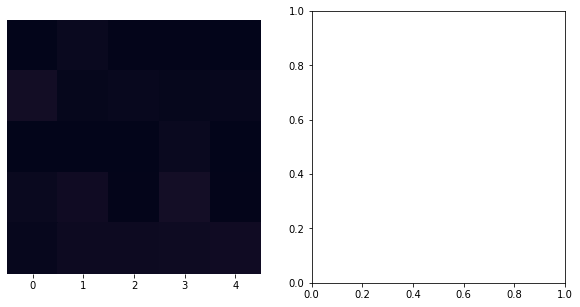

In [43]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
draw(torch.abs(autoencoder.d_mask.detach().squeeze()), list(range(5)), list(range(5)) if n_heads ==0 else [], ax=axs[0])
draw(torch.abs(mask_norm.detach().squeeze()), list(range(5)), list(range(5)) if n_heads ==0 else [], ax=axs[1])
plt.show()

In [ ]:
g.draw_graph()

In [ ]:
time_scores(mask_norm.squeeze().transpose(0,1))
torch.argsort(time_scores(mask_norm.squeeze().transpose(0,1)))

In [ ]:
autoencoder.decoder.layers[1].self_attn.attn[0, 0].data

In [ ]:
sent = list(range(5))
tgt_sent = list(range(5))

autoencoder.decoder.layers[0].self_attn.attn[0, 0].data

for layer in range(0,2):
    fig, axs = plt.subplots(1,2, figsize=(10, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(1):
        draw(autoencoder.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent[:-1], tgt_sent[:-1] if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,2, figsize=(10, 10))
    for h in range(1):
        draw(autoencoder.decoder.layers[layer].src_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
pass;